In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
from skimage.feature import hog
from skimage import exposure
from skimage import segmentation
from sklearn.cluster import KMeans
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import naive_bayes
import os
from funcionesProyecto import funcionLeerClase, funcionLeerTodasClases, ecualizacionAdaptativa, imagen_media_color, quitarFondo, generarHogClase, generarCsv

In [8]:
lista10c,lista1c,lista1e,lista20c,lista2c,lista2e,lista50c,lista5c = funcionLeerTodasClases('train')

En train/10c, hay 254 ejemplos
En train/1c, hay 77 ejemplos
En train/1e, hay 248 ejemplos
En train/20c, hay 227 ejemplos
En train/2c, hay 25 ejemplos
En train/2e, hay 45 ejemplos
En train/50c, hay 131 ejemplos
En train/5c, hay 284 ejemplos


In [9]:
def umbralAdaptativo(img):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (15, 15), 0)
    thresholded = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 3, 1)
    return thresholded

In [10]:
def umbralGeneral(img):
    gray_blur = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh, imgBinaria = cv2.threshold()

In [11]:
def cerrarHuecos(img):
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=4)
    '''
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=4)'''
    return closing

In [12]:
def detectarCirculos(closing, img):
    nuevaImg = img.copy()
    cont_img = closing.copy()
    contours, hierarchy = cv2.findContours(cont_img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 30:
            continue
        if (len(cnt) < 5):
            continue
        ((x,y), r) = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        cv2.circle(img = nuevaImg, center=center, radius=int(r), color=(0, 255, 0), thickness=1)
    return nuevaImg

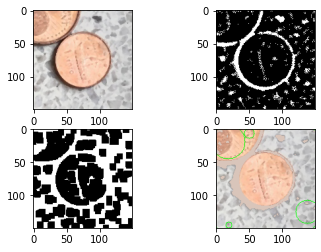

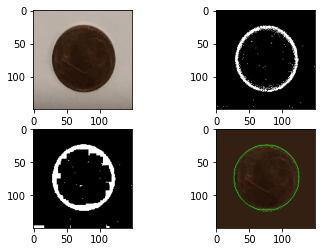

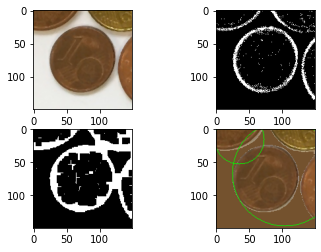

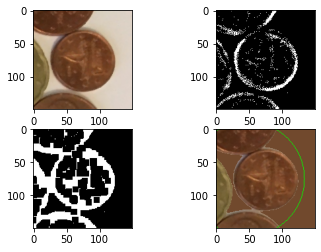

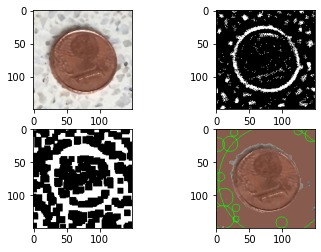

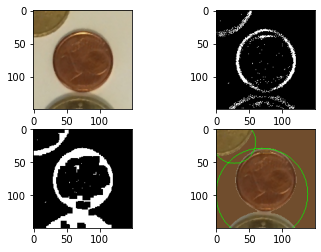

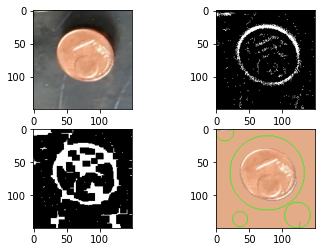

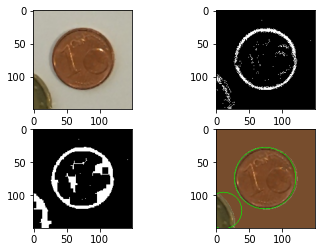

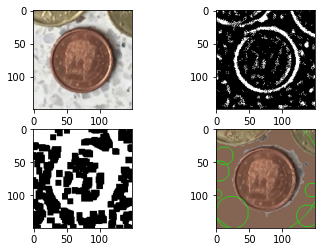

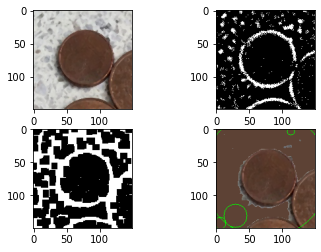

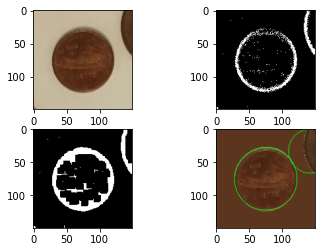

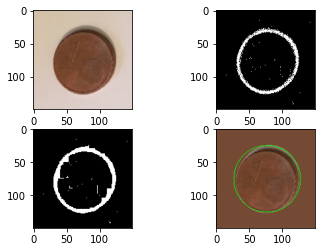

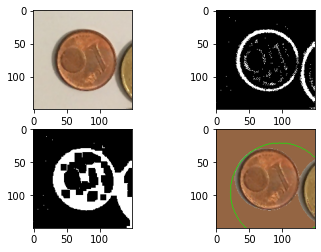

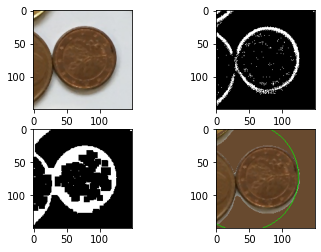

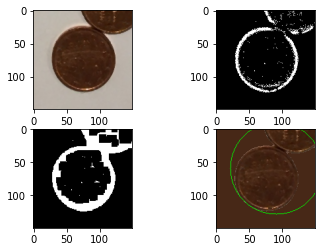

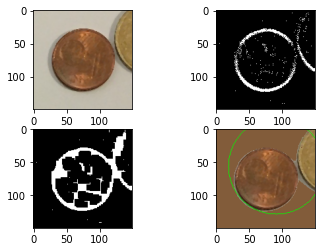

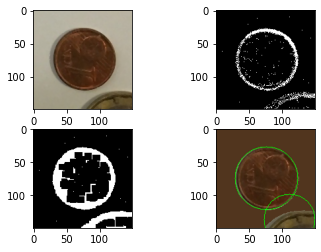

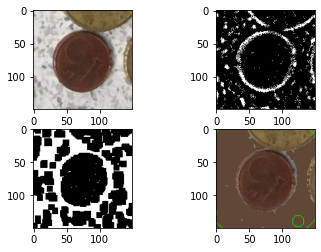

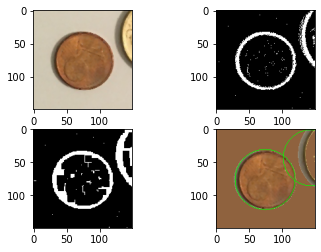

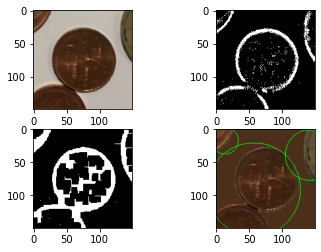

In [13]:
imagenes = lista1c
for img in imagenes[:20]:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenSinFondo = quitarFondo(img)
    imagenSinFondoOriginal = img.copy()
    plt.subplot(221), plt.imshow(img)
    thresholded = umbralAdaptativo(img)
    plt.subplot(222), plt.imshow(thresholded,cmap='gray')
    closing = cerrarHuecos(thresholded)
    plt.subplot(223), plt.imshow(closing, cmap = 'gray')
    conCirculos = detectarCirculos(closing, imagenSinFondo)
    plt.subplot(224), plt.imshow(conCirculos, cmap = 'gray')
    grayOutput = cv2.cvtColor(conCirculos, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(imagenSinFondoOriginal, cv2.COLOR_RGB2GRAY)
    siluetaMoneda = gray-grayOutput
    mascaraMoneda = np.copy(siluetaMoneda)
    cnts = cv2.findContours(mascaraMoneda, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cv2.fillPoly(mascaraMoneda, cnts, (255, 255, 255))
    imagenSinFondo[closing==0] = 0
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    plt.show()

In [ ]:
imagenes = lista1c
for img in imagenes[:20]:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenSinFondo = quitarFondo(img)
    imagenSinFondoOriginal = img.copy()
    plt.subplot(221), plt.imshow(img)
    thresholded = umbralAdaptativo(img)
    plt.subplot(222), plt.imshow(thresholded,cmap='gray')
    closing = cerrarHuecos(thresholded)
    plt.subplot(223), plt.imshow(closing, cmap = 'gray')
    imagenSinFondo[closing==0] = 0
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    plt.subplot(224), plt.imshow(imagenSinFondo, cmap = 'gray')
    plt.show()

In [ ]:
imagenes = lista1c
for img in imagenes[:20]:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imagenMedia, colorMoneda = imagen_media_color(img, 2)
    '''
    imagenMedia = cv2.cvtColor(imagenMedia.astype('uint8'), cv2.COLOR_RGB2GRAY)
    imagenMedia = 255-imagenMedia
    '''
    
    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.imshow(imagenMedia,cmap='gray')
    
    imagenSinFondo = quitarFondo(img)
    imagenSinFondo = encontrarMonedaCentral(imagenSinFondo,  plt.subplot(223))
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    
    #imagenSinFondo = realceBordes(imagenSinFondo, a = 2, tamKernel = 5)
        
    plt.subplot(224), plt.imshow(imagenSinFondo, cmap = 'gray')
    
    fd, hog_image = hog(imagenSinFondo, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))
    
    plt.show()
    plt.figure(), plt.imshow(hog_image_rescaled, cmap = 'gray')
    plt.show()

In [35]:
def quitarFondoGaussiana(img):
    #imgBlurreadaGaussiana = cv2.GaussianBlur(img,(3,3),0)
    imagenMedia, colorMoneda = imagen_media_color(img, nClusters = 2)
    puntoCentro = (img.shape[0]//2,img.shape[1]//2)
    imagenSinFondo = img.copy()
    posFondo = np.any(imagenMedia != imagenMedia[puntoCentro], axis = 2)
    #Ponemos el fondo del mismo color que la moneda
    imagenSinFondo[posFondo] = colorMoneda
    return imagenSinFondo

In [32]:
def quitarFondoMedia(img):
    imgBlurreadaGaussiana = cv2.blur(img,(3,3))
    imagenMedia, colorMoneda = imagen_media_color(imgBlurreadaGaussiana, nClusters = 2)
    puntoCentro = (img.shape[0]//2,img.shape[1]//2)
    imagenSinFondo = img.copy()
    posFondo = np.any(imagenMedia != imagenMedia[puntoCentro], axis = 2)
    #Ponemos el fondo del mismo color que la moneda
    imagenSinFondo[posFondo] = colorMoneda
    return imagenSinFondo

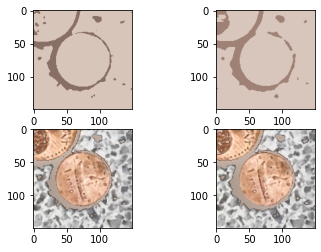

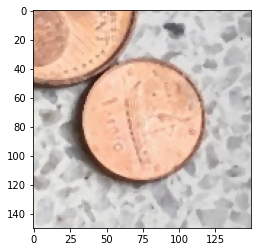

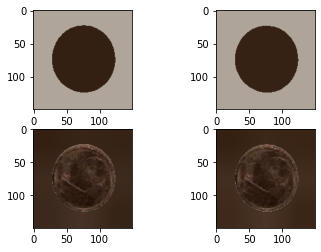

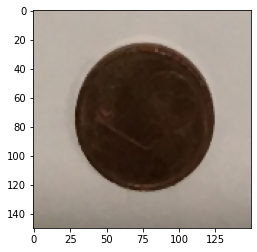

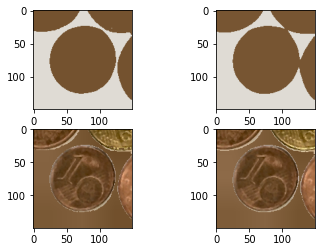

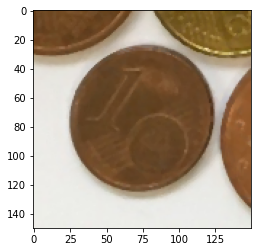

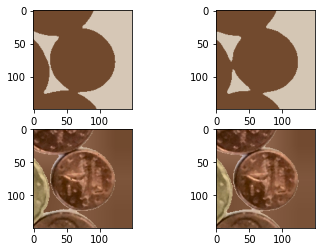

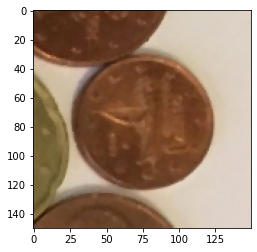

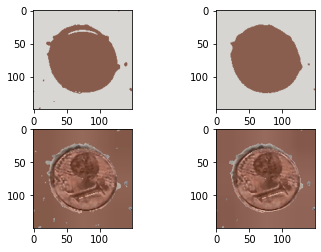

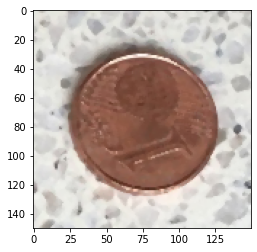

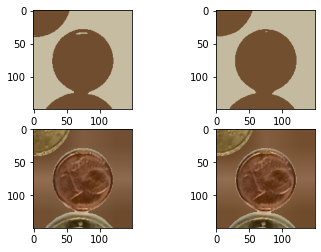

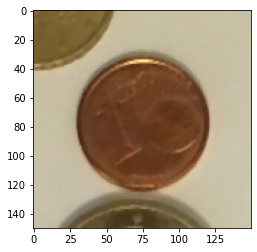

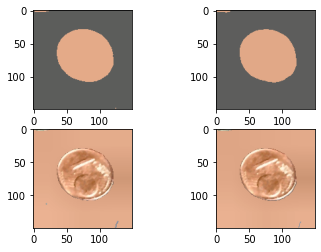

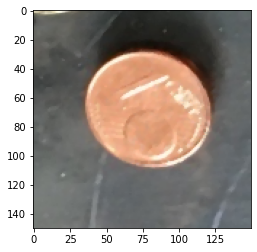

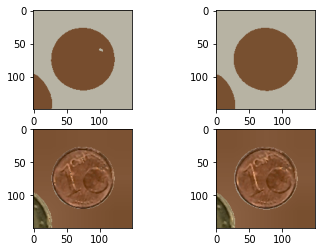

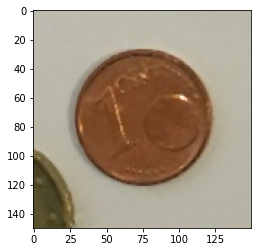

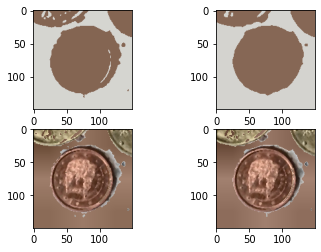

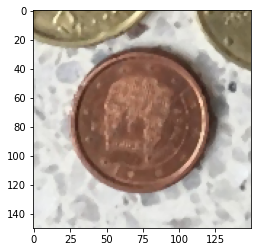

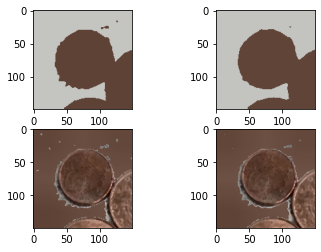

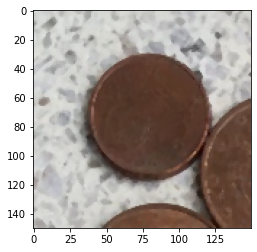

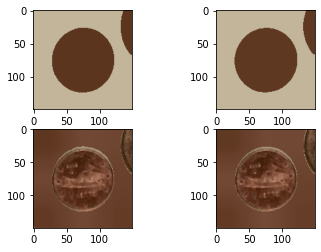

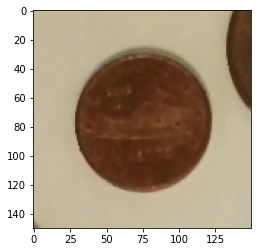

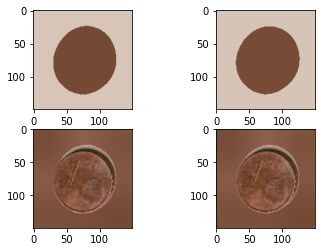

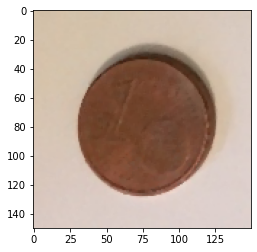

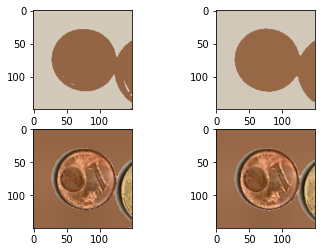

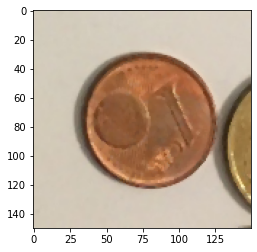

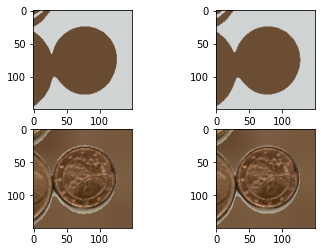

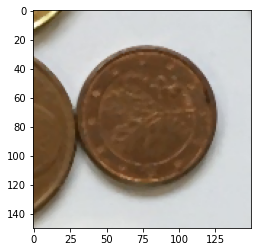

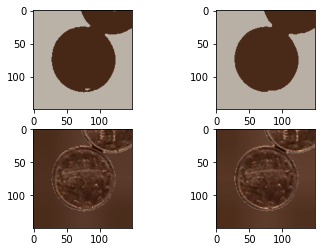

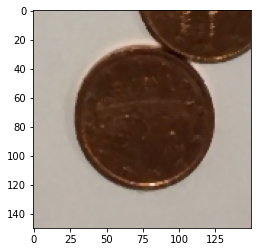

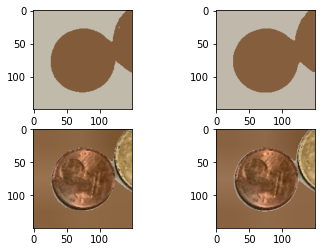

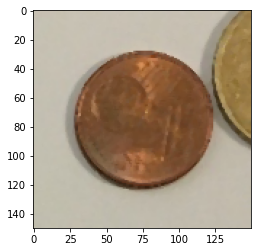

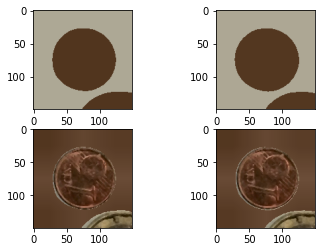

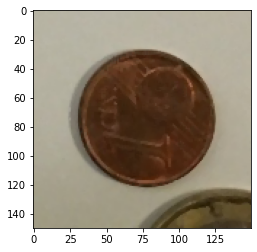

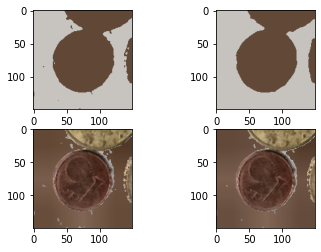

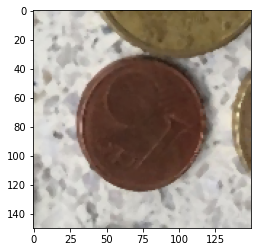

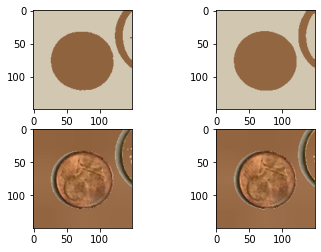

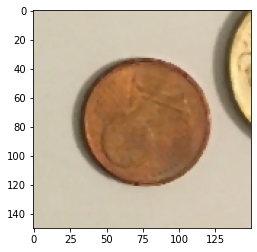

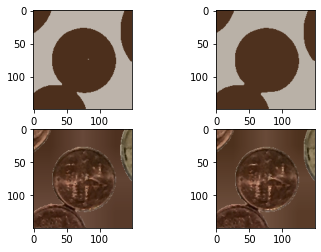

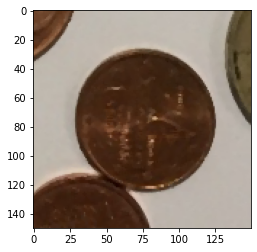

In [36]:
imagenes = lista1c
for img in imagenes[:20]:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgBlurreadaMedia = cv2.blur(img,(7,7))
    imgBlurreadaGaussiana = cv2.GaussianBlur(img,(5,5),0)
    imagenMedia, colorMoneda = imagen_media_color(imgBlurreadaMedia, 2)
    imagenGaussiana, colorMoneda = imagen_media_color(imgBlurreadaGaussiana, 2)
    imagenSinFondoGaussiana = quitarFondoGaussiana(img)
    imagenSinFondoGaussiana = ecualizacionAdaptativa(imagenSinFondoGaussiana)
    imagenSinFondoMedia = quitarFondoMedia(img)
    imagenSinFondoMedia = ecualizacionAdaptativa(imagenSinFondoMedia)
    plt.subplot(221), plt.imshow(imagenGaussiana)
    plt.subplot(222), plt.imshow(imagenMedia,cmap='gray')
    plt.subplot(223), plt.imshow(imagenSinFondoGaussiana,cmap='gray')
    plt.subplot(224), plt.imshow(imagenSinFondoMedia, cmap = 'gray')
    plt.show()
    plt.figure(), plt.imshow(img, cmap = 'gray')
    plt.show()

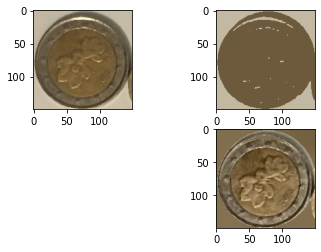

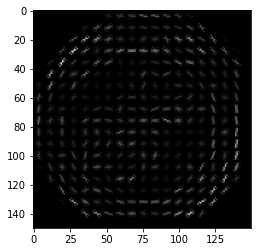

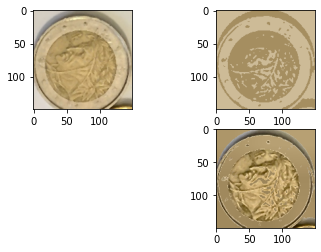

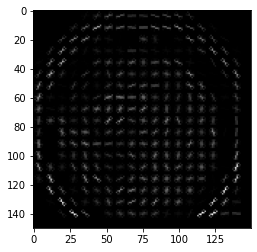

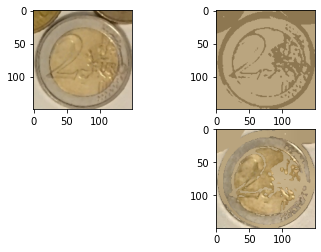

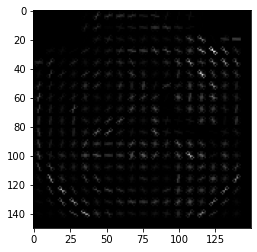

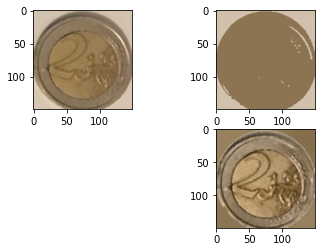

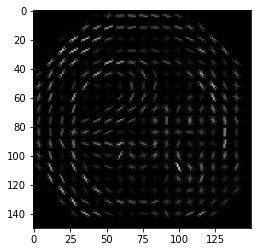

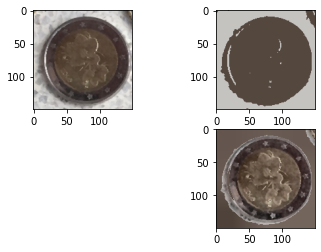

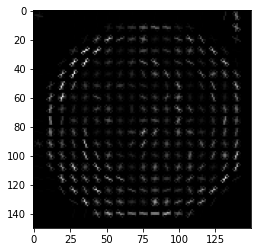

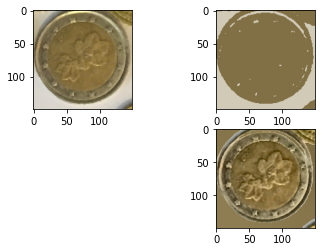

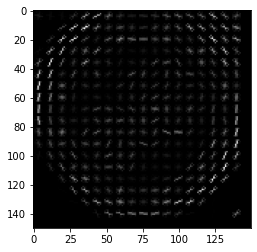

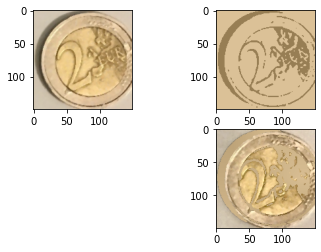

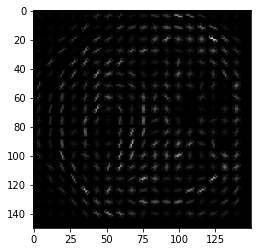

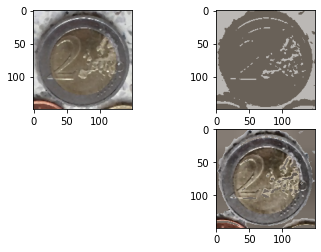

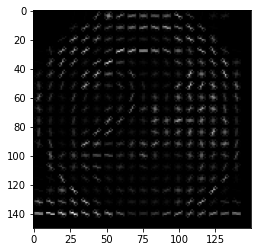

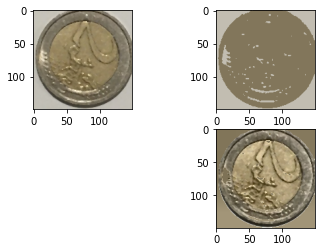

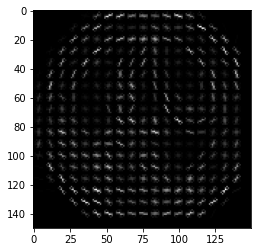

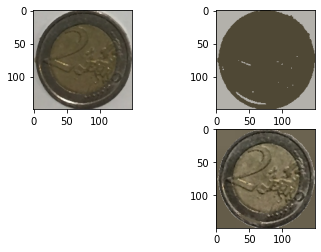

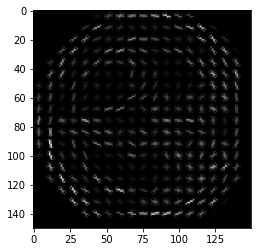

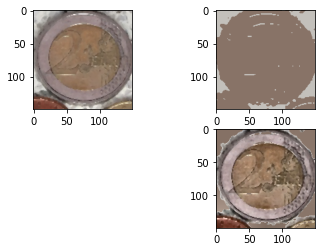

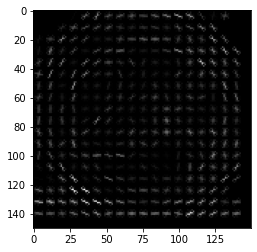

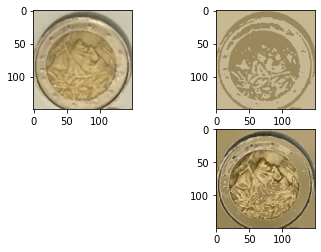

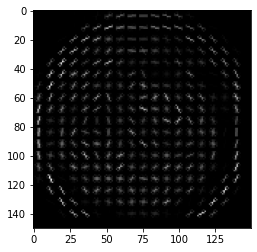

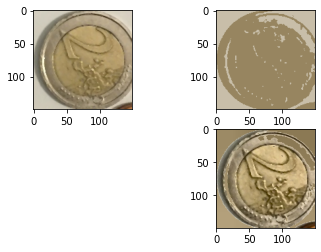

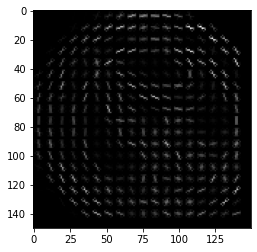

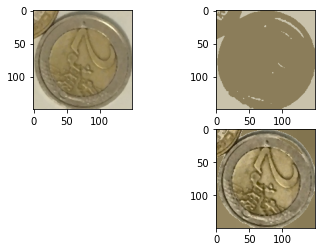

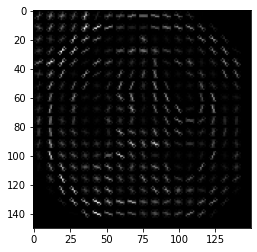

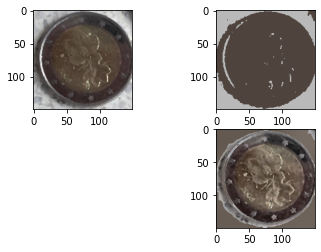

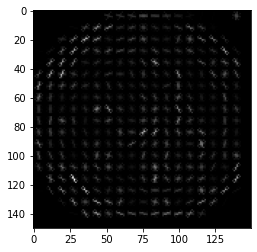

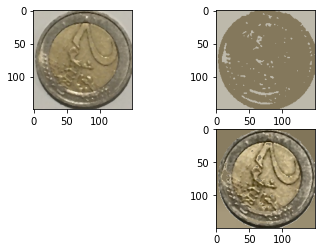

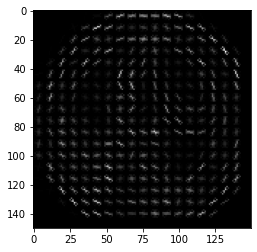

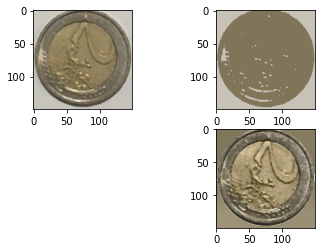

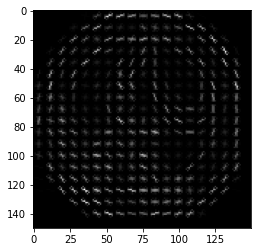

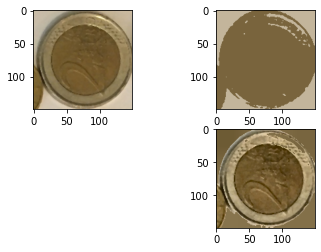

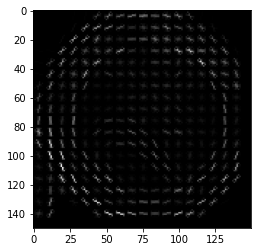

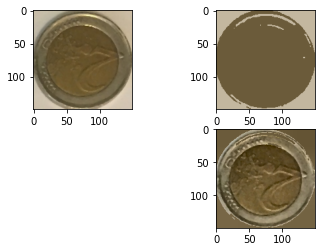

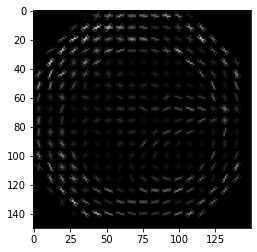

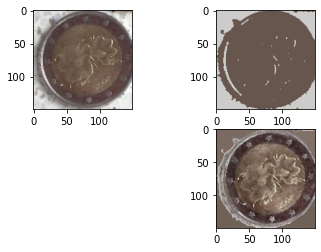

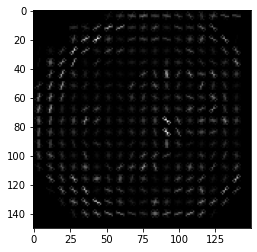

In [8]:
imagenes = lista2e
for img in imagenes[:20]:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenMedia, colorMoneda = imagen_media_color(img, 2)
    imagenSinFondo = quitarFondo(img)
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.imshow(imagenMedia,cmap='gray')            
    plt.subplot(224), plt.imshow(imagenSinFondo, cmap = 'gray')
    fd, hog_image = hog(imagenSinFondo, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))
    
    plt.show()
    plt.figure(), plt.imshow(hog_image_rescaled, cmap = 'gray')
    plt.show()

<br/><br/>**<u>PREPARAMOS LOS DATOS</u>:**<br/><br/><br/><br/>

In [ ]:
datosLista, numeroImagenes = funcionLeerTodasClases2('train')
print('Hay {} imagenes'.format(numeroImagenes))

In [ ]:
fd = hog(datosLista[0][0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7))
numeroColumnas = fd.size
datos = np.empty((0,numeroColumnas+1))
for i,clase in enumerate(datosLista):
    claseHog = []
    for img in clase:
        img = cv2.medianBlur(img,3)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imagenSinFondo = encontrarMonedaCentral(img)
        imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
        imagenSinFondo = realceBordes(imagenSinFondo, a = 2, tamKernel = 5)
        fd = hog(imagenSinFondo, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7))
        claseHog.append(fd)
    array = np.array(claseHog)
    array = np.hstack((array, np.full((array.shape[0], 1), i)))
    print(array.shape)
    datos = np.vstack((datos, array))
print(datos.shape)

In [ ]:
def aplicaPCA(imagen,nComponentes = None):
    pca = PCA(n_components=nComponentes)
    PCAs = pca.fit_transform(imagen)
    print('De media mantenemos el {}% de la información de los cuadros'.format(round(np.sum(pca.explained_variance_ratio_)*100, 2)))
    return PCAs, pca

In [ ]:
X = datos[:,:-1]
y = datos[:,-1].reshape(-1,1)
print(X.shape, y.shape)

In [ ]:
pca = PCA()
PCAs = pca.fit_transform(X)
print('De media mantenemos el {}% de la información de los cuadros'.format(round(np.sum(pca.explained_variance_ratio_)*100, 2)))
print(PCAs.shape)

In [ ]:
from joblib import dump, load
dump(pca, 'pca_model.joblib')

In [ ]:
datos = np.hstack((PCAs,y))

In [ ]:
np.savetxt('datosTrain.csv', datos, delimiter=",")

In [ ]:
datosNuevos = np.loadtxt('datosTrain.csv', delimiter=",")
print(datosNuevos.shape)
X = datosNuevos[:,:-1]
y = datosNuevos[:,-1].reshape(-1,1)
print(X.shape, y.shape)

In [ ]:
datosTest = funcionLeerClase('public_test')
print(len(datosTest))

In [ ]:
fd = hog(datosTest[0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7))
numeroColumnas = fd.size
claseHog = []
for img in datosTest:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenSinFondo = encontrarMonedaCentral(img)
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    imagenSinFondo = realceBordes(imagenSinFondo, a = 2, tamKernel = 5)
    fd, hog_image = hog(imagenSinFondo, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(7, 7), visualize=True)
    claseHog.append(fd)
test = np.array(claseHog)

In [ ]:
print(test.shape)

In [ ]:
PCAs_test = pca.transform(test)
print(PCAs_test.shape)

In [ ]:
np.savetxt('datosTest.csv', PCAs_test, delimiter=",")

In [ ]:
PCAs_test = np.loadtxt('datosTest.csv', delimiter=",")
print(PCAs_test.shape)

<br/><br/>**<u>PROBAMOS SVM</u>:**<br/><br/><br/><br/>

In [ ]:
svc = svm.SVC()
svc = svc.fit(X,y.ravel())
accTrain = svc.score(X,y)
print(accTrain)

In [ ]:
#Hacernos una idea del rendimiento: partimos train en tres conjuntos
C_values = [10**-4,10**-3,10**-2, 0.1,1,2,3,4, 10, 100]
gamma_values = [10**-4,10**-3,10**-2, 0.1,1, 10, 100]
params = {'C': C_values, 'gamma': gamma_values}
rs = ShuffleSplit(n_splits=1, test_size= 0.2, random_state=0)
svc = svm.SVC()
clf = GridSearchCV(svc, params, cv=rs, n_jobs=-1)
clf = clf.fit(Xtrain,ytrain.ravel())
C_best = clf.best_params_['C']
gamma_best = clf.best_params_['gamma']
print("Mejores parámetros C: {}, gamma: {}".format(C_best, gamma_best))
svc = svm.SVC(gamma=gamma_best, C=C_best)
svc = svc.fit(Xtrain,ytrain.ravel())
print('PRECISION:')
accTrain = svc.score(Xtrain,ytrain)
print('\tTRAIN:', accTrain)
accVal = svc.score(Xval,yval)
print('\tVAL:', accVal)
accTest = svc.score(Xtest,ytest)
print('\tTEST:', accTest)

In [ ]:
test_labels = svc.predict(test)

<br/><br/>**<u>PROBAMOS NAIVE BAYES</u>:**<br/><br/><br/><br/>

In [ ]:
nb = naive_bayes.GaussianNB()
nb = nb.fit(X,y.ravel())
test_labels = nb.predict(X)
Etrain = metrics.mean_squared_error(test_labels, y)
print(Etrain)

<br/><br/>**<u>PROBAMOS REDES</u>:**<br/><br/><br/><br/>

In [ ]:
from sklearn.neural_network import MLPClassifier
#RED NEURONAL
rs = ShuffleSplit(n_splits=1, test_size= 0.2, random_state=0)
hidden_sizes = range(1, 25, 2)
metodoPesos = ['lbfgs', 'sgd', 'adam']
funcionActivacion = ['identity', 'logistic', 'tanh', 'relu']
clf = MLPClassifier(max_iter = 250)
parameters = {'hidden_layer_sizes': hidden_sizes, 'solver': metodoPesos, 'activation': funcionActivacion}
gridSearch = GridSearchCV(clf, scoring = 'neg_mean_squared_error',param_grid = parameters, cv=rs, n_jobs=-1)
gridSearch = gridSearch.fit(X,y)
hidden_layer_sizes_best = gridSearch.best_params_['hidden_layer_sizes']
funcionActivacion_best = gridSearch.best_params_['activation']
metodoPesos_best = gridSearch.best_params_['solver']
clf = MLPClassifier(max_iter = 250, hidden_layer_sizes = hidden_layer_sizes_best, solver = metodoPesos_best,activation =  funcionActivacion_best)
clf = clf.fit(X,y)
salidasTrain = clf.predict(X)
Etrain = metrics.mean_squared_error(salidasTrain, y)
print(Etrain)

In [ ]:
test_labels = clf.predict(test)

<br/><br/>**<u>PARA GENERAR CSV RESULTADOS</u>:**<br/><br/><br/><br/>

In [ ]:
ejemplo_dir = 'public_test'
contenido = os.listdir(ejemplo_dir)
test_image_ids = []
for fichero in contenido:
    if os.path.isfile(os.path.join(ejemplo_dir, fichero)) and fichero.endswith('.jpg'):
        test_image_ids.append(fichero)

In [ ]:
import csv
fields = ["Id", "Expected"] 
filename = "results.csv"

# writing to csv file 
with open(filename, 'w', newline="") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile, delimiter=',') 

    # writing the fields 
    csvwriter.writerow(fields) 

    # writing the data rows 
    for i in range(len(test_labels)):
        csvwriter.writerow([test_image_ids[i], int(test_labels[i])])

In [ ]:
#para hacer las particiones
Xtrain, Xval_test, ytrain, yval_test = train_test_split(X, y, test_size=0.4, random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xval_test, yval_test, test_size=0.5, random_state=42)